# Volatility Stop

https://www.linnsoft.com/techind/volatility-stop-vstop

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AAPL'
start = '2018-09-01'
end = '2019-01-01'

# Read data 
df = yf.download(symbol,start,end)

# View Columns
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-04,57.102501,57.294998,56.657501,57.090000,54.461617,109560400
2018-09-05,57.247501,57.417500,56.275002,56.717499,54.106262,133332000
2018-09-06,56.557499,56.837502,55.325001,55.775002,53.207169,137160000
2018-09-07,55.462502,56.342499,55.177502,55.325001,52.777878,150479200
2018-09-10,55.237499,55.462502,54.117500,54.582500,52.069557,158066000


In [3]:
mult = 2  # True Range Multiplier

df['TR'] = df['High'] - df['Low']

# Calculate initial VSTOP values
df['VSTOP'] = np.nan
df['Trend'] = 0  # 1 for up, -1 for down

# Detect initial trend
if df['Close'].iloc[0] > df['Close'].iloc[1]:
    df.at[df.index[0], 'Trend'] = 1
else:
    df.at[df.index[0], 'Trend'] = -1

# Initialize first VSTOP value
if df.at[df.index[0], 'Trend'] == 1:
    df.at[df.index[0], 'VSTOP'] = df['Close'].iloc[0] - mult * df['TR'].iloc[0]
else:
    df.at[df.index[0], 'VSTOP'] = df['Close'].iloc[0] + mult * df['TR'].iloc[0]

# Loop through the data to calculate VSTOP and trend
for i in range(1, len(df)):
    cl = df['Close'].iloc[i]
    tr = df['TR'].iloc[i]
    vstop_prev = df['VSTOP'].iloc[i - 1]
    trend = df['Trend'].iloc[i - 1]
    
    if trend == 1:  # Uptrend
        vstop = max(vstop_prev, cl - mult * tr)
        if cl < vstop:
            trend = -1  # Trend reversal to downtrend
            vstop = cl + mult * tr
    else:  # Downtrend
        vstop = min(vstop_prev, cl + mult * tr)
        if cl > vstop:
            trend = 1  # Trend reversal to uptrend
            vstop = cl - mult * tr

    df.at[df.index[i], 'VSTOP'] = vstop
    df.at[df.index[i], 'Trend'] = trend


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,TR,VSTOP,Trend
Date,,,,,,,,,
2018-09-04,57.102501,57.294998,56.657501,57.090000,54.461617,109560400,0.637497,55.815006,1
2018-09-05,57.247501,57.417500,56.275002,56.717499,54.106262,133332000,1.142498,55.815006,1
2018-09-06,56.557499,56.837502,55.325001,55.775002,53.207169,137160000,1.512501,58.800003,-1
2018-09-07,55.462502,56.342499,55.177502,55.325001,52.777878,150479200,1.164997,57.654995,-1
2018-09-10,55.237499,55.462502,54.117500,54.582500,52.069557,158066000,1.345001,57.272503,-1


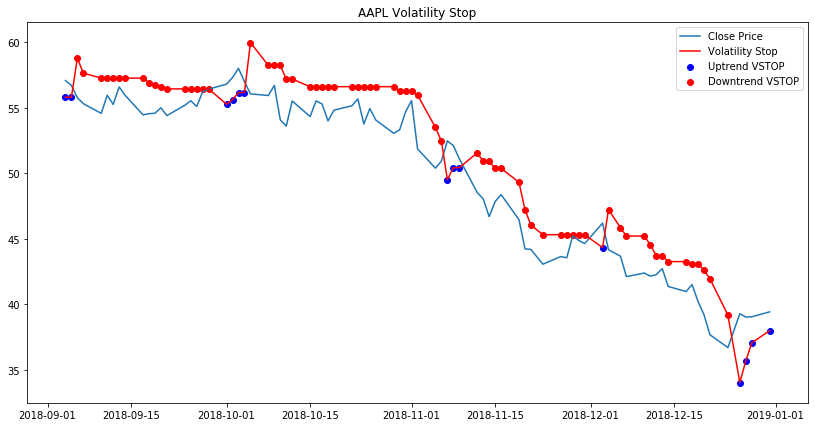

In [5]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['VSTOP'], color='red', label='Volatility Stop')

# Coloring the VSTOP based on trend
up_trend = df[df['Trend'] == 1]
down_trend = df[df['Trend'] == -1]

plt.scatter(up_trend.index, up_trend['VSTOP'], color='blue', label='Uptrend VSTOP')
plt.scatter(down_trend.index, down_trend['VSTOP'], color='red', label='Downtrend VSTOP')

plt.title(f'{symbol} Volatility Stop')
plt.legend()
plt.show()

## Candlestick with Volatility Stop

In [6]:
from matplotlib import dates as mdates
import datetime as dt

dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
dfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,TR,VSTOP,Trend,VolumePositive
0,736941.0,57.102501,57.294998,56.657501,57.090000,54.461617,109560400,0.637497,55.815006,1,False
1,736942.0,57.247501,57.417500,56.275002,56.717499,54.106262,133332000,1.142498,55.815006,1,False
2,736943.0,56.557499,56.837502,55.325001,55.775002,53.207169,137160000,1.512501,58.800003,-1,False
3,736944.0,55.462502,56.342499,55.177502,55.325001,52.777878,150479200,1.164997,57.654995,-1,False
4,736947.0,55.237499,55.462502,54.117500,54.582500,52.069557,158066000,1.345001,57.272503,-1,False


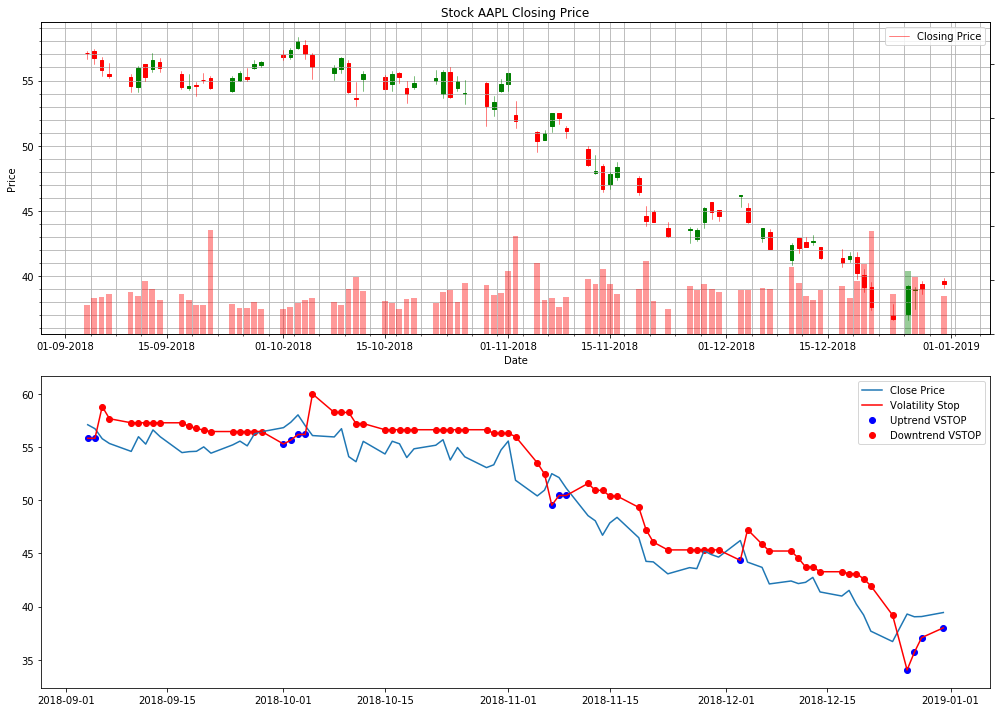

In [7]:
from mplfinance.original_flavor import candlestick_ohlc

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1, dfc[['Date', 'Open', 'High', 'Low', 'Close']].values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3 * dfc.Volume.max())
ax1.set_title('Stock ' + symbol + ' Closing Price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')
ax1.legend(['Closing Price'], loc='best')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df.index, df['Close'], label='Close Price')
ax2.plot(df.index, df['VSTOP'], color='red', label='Volatility Stop')

up_trend = df[df['Trend'] == 1]
down_trend = df[df['Trend'] == -1]

ax2.scatter(up_trend.index, up_trend['VSTOP'], color='blue', label='Uptrend VSTOP')
ax2.scatter(down_trend.index, down_trend['VSTOP'], color='red', label='Downtrend VSTOP')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

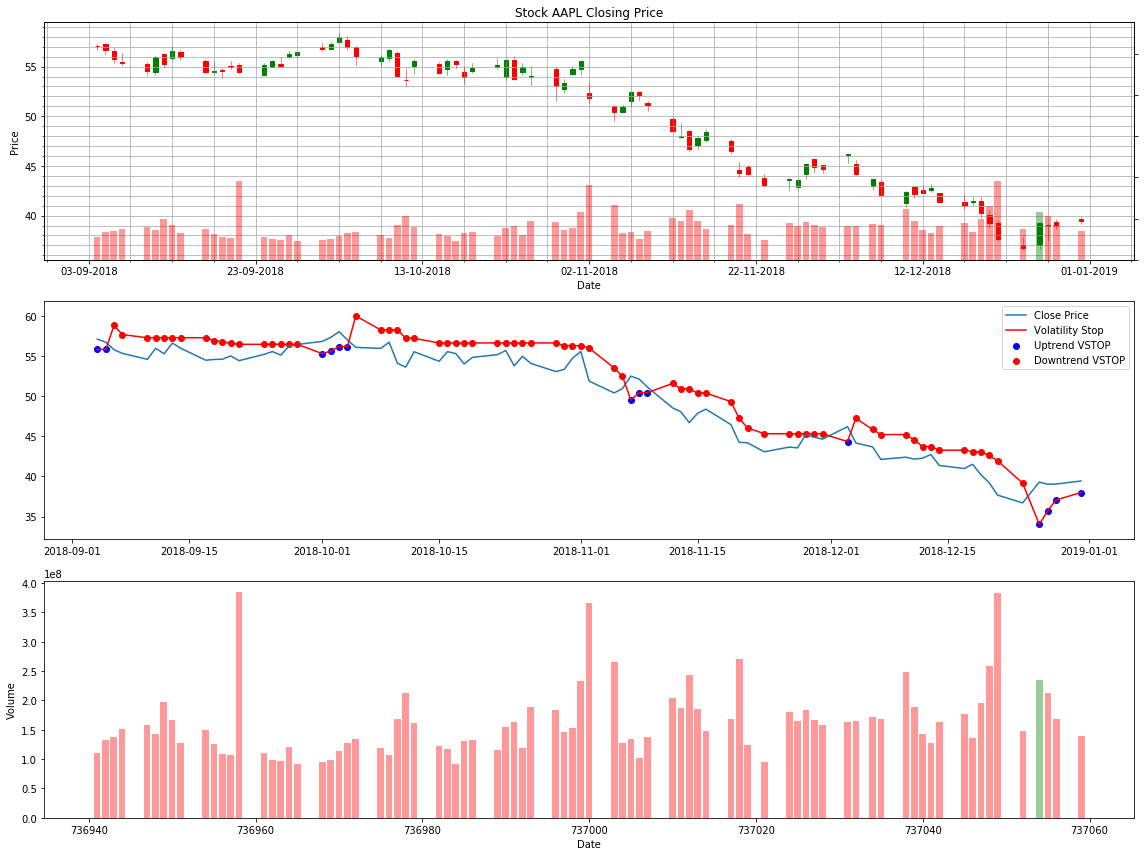

In [8]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot(3, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

ax2 = plt.subplot(3, 1, 2)
ax2.plot(df.index, df['Close'], label='Close Price')
ax2.plot(df.index, df['VSTOP'], color='red', label='Volatility Stop')

up_trend = df[df['Trend'] == 1]
down_trend = df[df['Trend'] == -1]

ax2.scatter(up_trend.index, up_trend['VSTOP'], color='blue', label='Uptrend VSTOP')
ax2.scatter(down_trend.index, down_trend['VSTOP'], color='red', label='Downtrend VSTOP')
ax2.legend(loc='best')

ax3 = plt.subplot(3, 1, 3)
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax3.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax3.set_ylabel('Volume')
ax3.set_xlabel('Date')

plt.tight_layout()
plt.show()